## Code for 1D Simulation of Exclusive Active Matter in the Hydrodynamic Limit 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba.experimental import jitclass
from numba import njit
import dim_one_sim  

### Some simple sims for illustrative purposes

0.9782998310222139
0.09963204122669095


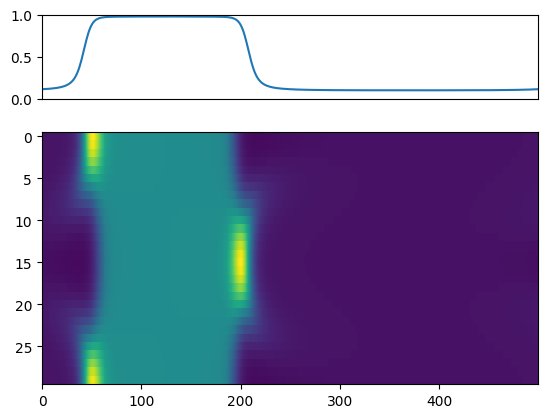

In [250]:
f = test_f.f
#if we want to normalize by local density
row_sums = f.sum(axis=1)
new_matrix = f / row_sums[:, np.newaxis]
fig, (ax1, ax2) = plt.subplots(2, height_ratios=(1,3))
ax2.imshow(f.T, aspect='auto', interpolation='none', vmin=0.0)
rho_ = test_f.history_rho[-1]
ax1.plot(rho_)
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.set_xlim(left=0.0, right=N_x-1)
ax1.set_xticks([])
print(np.max(rho_))
print(np.min(rho_))

### Drawing Binodal and Spinodal Lines in 1D

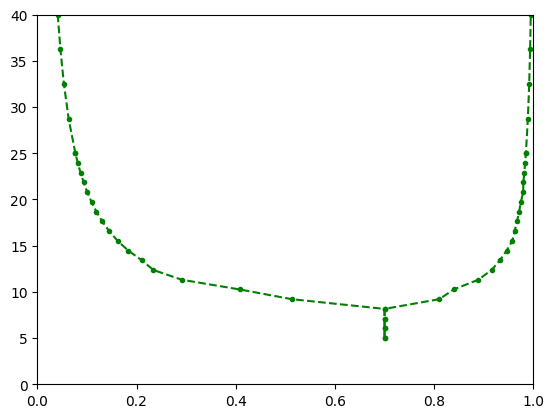

In [338]:
N_x = 500
N_theta = 30
end_time = 50.0



vapour_density = []
liquid_density = []
stability = []
v_0s = np.concatenate((np.linspace(5, 25, 20), np.linspace(25,40,5)))
for v_0 in v_0s:
    #initial condition
    test_f = dim_one_sim.f(N_x=N_x, N_theta=N_theta, v_0=v_0, L_x=20)
    phi=0.7
    a = phi*0.2
    for k in range(N_x):
        test_f.f[k, :] = (phi + a*np.sin(2*np.pi/N_x * k))/(2*np.pi)

    #evolve
    test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)

    rho_f = test_f.history_rho[-1]
    rho_i = test_f.history_rho[0]

    max_i, min_i = np.max(rho_i), np.min(rho_i)
    max_f, min_f = np.max(rho_f), np.min(rho_f)

    range_i = max_i - min_i
    range_f = max_f - min_f
    
    if range_f/range_i <= 1:
        stability.append(True)
        vapour_density.append(phi)
        liquid_density.append(phi)
    else:
        stability.append(False)
        vapour_density.append(min_f)
        liquid_density.append(max_f)


np.save('vap_density_'+str(phi), vapour_density)
np.save('liq_density_'+str(phi), liquid_density)

plt.plot(vapour_density, v_0s, '.--g')
plt.plot(liquid_density, v_0s, '.--g')

plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=40.0)
plt.show()

(0.0, 40.0)

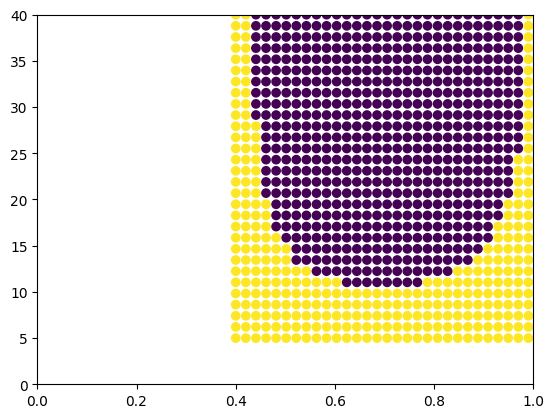

In [341]:

end_time = 100.0

stability = []
x_s = []
y_s = []
for phi in np.linspace(0.4, 0.99, 30):
    for v_0 in np.linspace(5.0, 40.0, 30):
        test_f = dim_one_sim.f(N_x=400, N_theta=10, v_0=v_0, L_x=20)
        test_f.set_random(phi=phi, delta=0.02)
        test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)
        
        rho_ = test_f.history_rho[-1]

        x_s.append(phi)
        y_s.append(v_0)

        if (np.max(rho_)-np.min(rho_)) >= 0.05:
            stability.append(0.0)
        else:
            stability.append(1.0)
np.save('stability', stability)


plt.scatter(x_s, y_s, c=stability)
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=40.0)



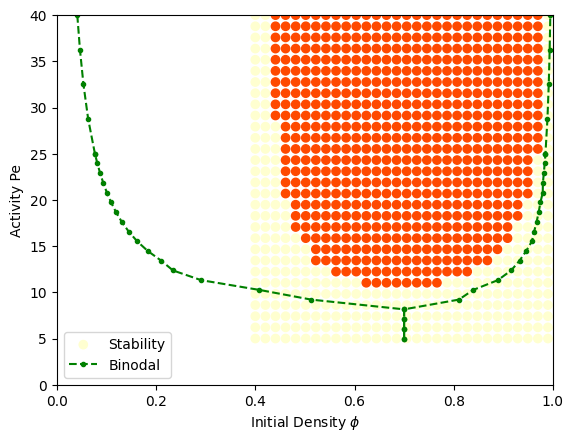

In [359]:
plt.scatter(x_s, y_s, c=stability, label='Stability', vmin=-1.0, vmax=1.1, cmap='hot')
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=40.0)


plt.plot(vapour_density, v_0s, '.--g', label='Binodal')
plt.plot(liquid_density, v_0s, '.--g')
plt.xlim(left=0.0, right=1.0)
plt.xlabel(r'Initial Density $\phi$')
plt.ylabel(r'Activity Pe')
plt.legend()

### Finding Unstable Modes

In [4]:
def d_s(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return (1-rho)*(1-alpha*rho + beta*rho**2)

def d_s_prime(rho):
    alpha = np.pi/2 -1
    beta = alpha*(2*alpha-1)/(2*alpha+1)
    return -(alpha+1)+2*(alpha+beta)*rho -3*beta*rho**2


In [5]:
L=20.0
D_0 = 1.0
D_E = 1.0
l = np.sqrt(D_E/D_0)
omega = 2*np.pi/L

def a(phi):
    return -D_E*d_s(phi)*(omega)**2

def b(phi, Pe):
    return -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*d_s(phi)

def W(phi, Pe):
    W = np.array([
        [-D_E*(omega)**2, -np.sqrt(D_0*D_E)*Pe/2*1.0j*(omega)*(1-phi), 0, 0, 0, 0, 0, 0],
        [2*b(phi, Pe) - np.sqrt(D_0*D_E)*Pe*1.0j*omega*phi*d_s_prime(phi), a(phi)-1*D_0, b(phi, Pe), 0, 0, 0, 0, 0],
        [0, b(phi, Pe), a(phi) - 4*D_0, b(phi, Pe), 0, 0, 0, 0],
        [0, 0, b(phi, Pe), a(phi) - 9*D_0, b(phi, Pe), 0, 0, 0],
        [0, 0, 0, b(phi, Pe), a(phi) - 16*D_0, b(phi, Pe), 0, 0],
        [0, 0, 0, 0, b(phi, Pe), a(phi) - 25*D_0, b(phi, Pe), 0],
        [0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 36*D_0, 0],
        [0, 0, 0, 0, 0, 0, b(phi, Pe), a(phi) - 49*D_0]
    ])
    return W

def stability(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues = np.linalg.eigvals(W_)
    largest_real_part = np.max(eigenvalues.real)
    if largest_real_part >= 0.0:
        return 0.0
    else:
        return 1.0
    
stability_picture = np.array([[stability(phi, Pe) for phi in np.linspace(0, 1, 200)] for Pe in np.linspace(0, 40, 200)])



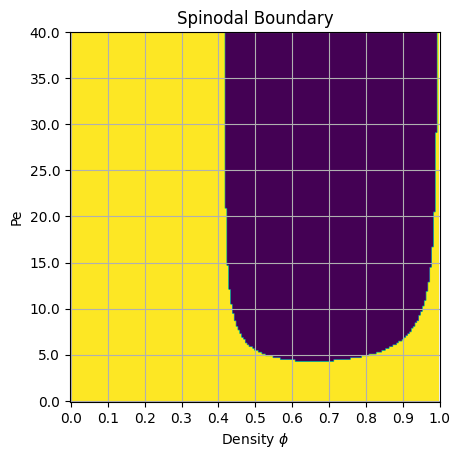

In [6]:
plt.imshow(stability_picture, origin='lower')
plt.xticks([])
plt.yticks(np.linspace(0, 200, 9), labels=np.linspace(0, 40, 9))
plt.xticks(np.linspace(0, 200, 11), labels=np.round(np.linspace(0, 1.0, 11), 3))
plt.xlabel(r'Density $\phi$')
plt.ylabel(r'Pe')
plt.title('Spinodal Boundary')
plt.grid()
plt.show()

In [7]:
def maximal_instability_function(phi, Pe):
    W_ = W(phi, Pe)
    eigenvalues, eigenvectors = np.linalg.eig(W_)

    # Find the index of the eigenvalue with the largest real part
    index_max_real = np.argmax(eigenvalues.real)
    A_n = eigenvectors[:, index_max_real]

    def f_0(x, theta):
        eigenfunction = np.real(np.sum([A_n[k] * np.cos(k*theta) * np.exp(1.0j * omega * x) for k in range(8)]))
        return eigenfunction
    
    return f_0


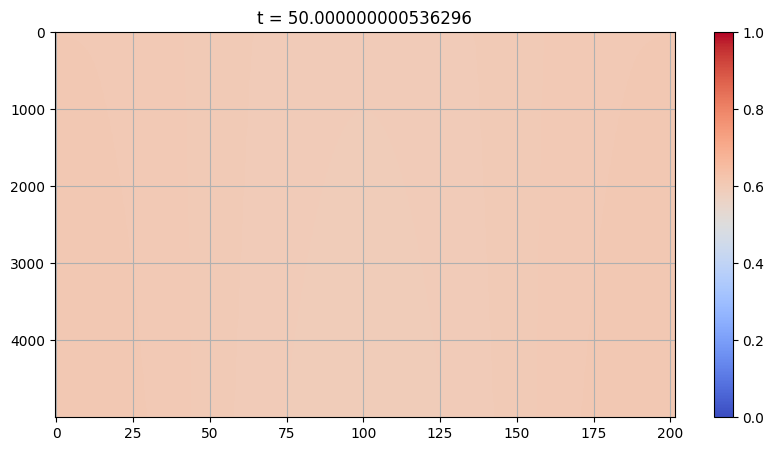

In [73]:
phi=0.6
Pe = 10

N_x = 200
N_theta = 30

test_f = dim_one_sim.f(N_x=N_x+2, N_theta=N_theta, v_0=Pe, L_x=20)

delta_f = maximal_instability_function(phi, Pe)
pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.001*pertubation)

end_time = 50.0
test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)
test_f.plot_history(y_breaks = 1, x_breaks=2)
plt.show() 

1.0 1.0


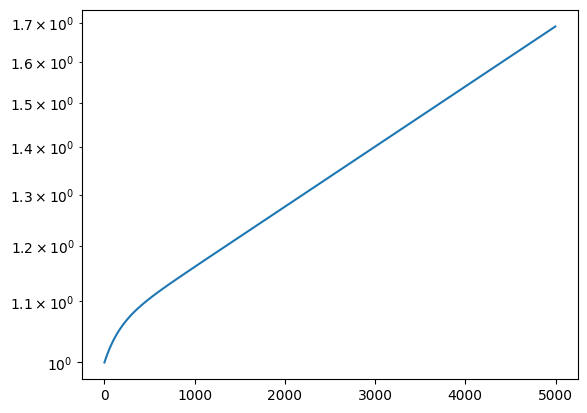

In [74]:
initial_dist = np.sqrt(np.sum(np.square(test_f.history_rho[0][1:-1] - phi)))
plt.plot([np.sqrt(np.sum(np.square(test_f.history_rho[i][1:-1]  - phi)))/initial_dist for i in range(len(test_f.history_rho))])
plt.yscale('log')

derivative = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - np.sqrt(np.sum(np.square(test_f.history_rho[-100][1:-1]  - phi))))
val = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - initial_dist)

print(derivative, val)


In [80]:
N_x = 200
N_theta = 30
stability = []
x_s = []
y_s = []
for phi in np.linspace(0.4, 0.99, 10):
    for v_0 in np.linspace(0.0, 40.0, 10):
        #set up initial condiiton
        test_f = dim_one_sim.f(N_x=N_x+2, N_theta=N_theta, v_0=Pe, L_x=20)
        delta_f = maximal_instability_function(phi, v_0)
        pertubation = np.array([[delta_f(x, theta) for theta in np.linspace(0, 2*np.pi, N_theta)] for x in np.linspace(0, 20, N_x)])
        test_f.f[1:-1, :] = np.copy(phi/(2*np.pi)*np.ones((N_x, N_theta)) + 0.001*pertubation)
        x_s.append(phi)
        y_s.append(v_0)

        #run sim
        end_time = 1.0
        test_f.evolve_to_time(t=end_time, recording_steps=1.0/200)        

        #analyse stability
        initial_dist = np.sqrt(np.sum(np.square(test_f.history_rho[0][1:-1] - phi)))
        derivative = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - np.sqrt(np.sum(np.square(test_f.history_rho[-50][1:-1]  - phi))))
        val = np.sign(np.sqrt(np.sum(np.square(test_f.history_rho[-1][1:-1]  - phi))) - initial_dist)

        if derivative*val >= 0.0:
            stability.append(val)
        else:
            stability.append(0.0)

np.save('stability', stability)

(0.0, 40.0)

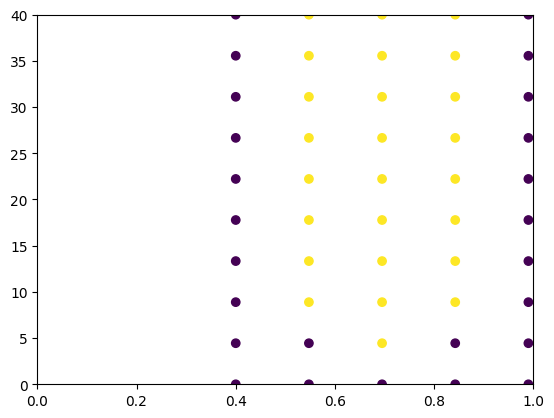

In [79]:
plt.scatter(x_s, y_s, c=stability)
plt.xlim(left=0.0, right=1.0)
plt.ylim(bottom=0.0, top=40.0)